In [1]:
from datetime import datetime, timedelta
import seaborn as sns
import pandas as pd
import numpy as np
import time
import sys
import os

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
%load_ext autoreload
%autoreload 2

from helpers.data_process import *
from helpers.plotting import *
from helpers.db_query import *
from helpers.feature_extraction import *

# Data processing

In [4]:
%time video_events = getVideoEvents(isa_only=True)

CPU times: user 29.6 s, sys: 2.3 s, total: 31.9 s
Wall time: 37 s


In [5]:
print(len(video_events))
video_events.head()

897942


,DataPackageID,AccountUserID,VideoID,TimeStamp,EventType,Year
0,EPFL-AlgebreLineaire-2019,95017,ca2fa02b0daa43f295e76da61e53de2a,2019-10-06 09:55:25,Video.Play,2019
1,EPFL-AlgebreLineaire-2019,99055,ff000e7ca278461e86a87a39248c5e76,2019-10-16 19:36:49,Video.Play,2019
2,EPFL-AlgebreLineaire-2018,47274,0ad048c708e944a1899ad2b552703b58,2018-11-13 13:41:11,Video.Play,2018
3,EPFL-AlgebreLineaire-2018,51498,639779353a1849199d151d3caaca5004,2018-12-05 16:43:39,Video.Seek,2018
4,EPFL-AlgebreLineaire-2019,95017,ab810821cd8943ea8a0173e900af8417,2019-09-21 16:27:10,Video.Pause,2019


In [6]:
%time problem_events = getProblemEvents(isa_only=True)

CPU times: user 13.4 s, sys: 932 ms, total: 14.4 s
Wall time: 15.5 s


In [7]:
print(len(problem_events))
problem_events.head()

440695


,DataPackageID,AccountUserID,ProblemID,TimeStamp,EventType
0,EPFL-AlgebreLineaire-2018,46461,44c46d58e2eb440b9308893be55aae3c,2018-12-01 15:18:00,Problem.Check
1,EPFL-AlgebreLineaire-2019,96442,eee03e5d86f04216a006f2995a6251cf,2019-12-05 19:28:36,Problem.Graded
2,EPFL-AlgebreLineaire-2018,11951,9066a9a110cc41fda2ac2ef9fb4fcd57,2018-10-28 14:01:30,Problem.Graded
3,EPFL-AlgebreLineaire-2019,91007,2ae6c4de2fbd4d5c8267795a5d572b6e,2019-09-22 09:32:37,Problem.Check
4,EPFL-AlgebreLineaire-2018,47544,156c7a9ac95047f59e1f524a2f3bd074,2018-10-09 10:45:29,Problem.Show


# Weekly feature engineering
| Measure | Meaning | Description | Source | 
| --- | --- | --- | --- |
| PDH | Peak on day hour | Identifies if a student's activities are centred around a particular hour of the day | [1] |
| PWD | Peak on week day | Identifies if a student's activities are centred around a particular day of the week | [1] |
| WS1 | Weekly Similarities in daily activity | Identifies if student works on same weekdays | [1] | 
| WS2 | Weekly Similarities in daily activity | Identifies if there is a similar distribution of workload among weekdays | [1] | 
| WS3 | Weekly Similarities in daily activity | Identifies if there is a similar time repartition of workload among weekdays | [1] | 
| FDH | Hourly Pattern over days | Identifies if hourly pattern is repeating over days | [1] | 
| FWH | Hourly Pattern over weeks | Identifies if hourly pattern is repeating over weeks| [1] | 
| FWD | Daily Pattern over Weeks | Identifies if daily pattern is repeating over weeks | [1] |
| NQZ | Number of quiz |Counts the total number of quiz completed by a student over the semester | - |
| PQZ | Percentage of quiz | Counts the percentage of quiz completed by a student over the flipped period| - |

In [8]:
def weekly_feature(df, feature, id=0):
    """
    Compute the feature over each week, delimited by start_ts and end_ts.
    """
    sid, T, Lw = getStudentTimeStamps(df, id=id)
    T = np.array(T)
    deltatime = np.array([timedelta(seconds=t) for t in T]) #Convert timestamps to timedelta for ease of use
    weekly_values = []
    start_ts, end_ts = timedelta(seconds=0), timedelta(weeks=1)
    max_ts = deltatime[-1]
    
    for week in range(Lw):
        start_ts = timedelta(weeks = week)
        end_ts = timedelta(weeks = week + 1)
        week_idx = np.where((deltatime >= start_ts) & (deltatime <= end_ts))[0]
        week_T = T[week_idx]
        weekly_values.append(feature(Lw, week_T))
        
    return weekly_values

weekly_feature(video_events, FWD)

[0.0, 0.4450418679126289, 0.0, 0.0, 0.44504186791262856]

In [9]:
def get_rand_id(X, year=None):
    if year:
        studentID =  list(X.loc[X.Year == year]["AccountUserID"].sample(1))[0]
    else:
        studentID =  list(X["AccountUserID"].sample(1))[0]
    return str(studentID)

def get_users(nb_user=10, year=2019):
     return [get_rand_id(video_events, year=year) for i in range(nb_user)]

In [10]:
def plot_weekly_feature(df, feature, nb_user=10, year=2019, users=None):
    users = get_users(nb_user, year) if not users else users
    weekly_val = np.array(list(map(lambda sid: weekly_feature(df, feature, sid), users)))
    xlabels = ["Week " + str(i) for i in range(weekly_val.shape[1])]
    ylabels = ["User " + str(i)  for i in range(weekly_val.shape[0])]
    sns.heatmap(weekly_val, xticklabels=xlabels, yticklabels=ylabels);

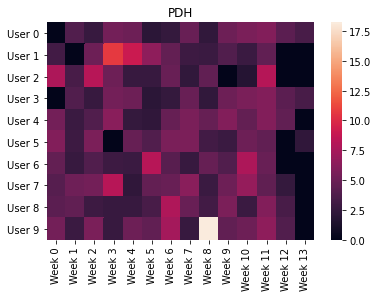

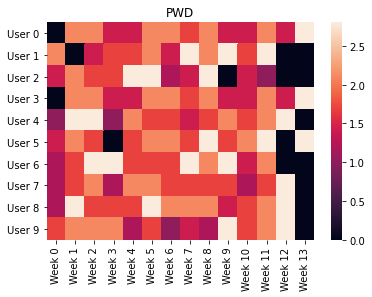

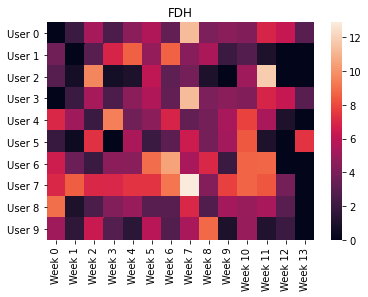

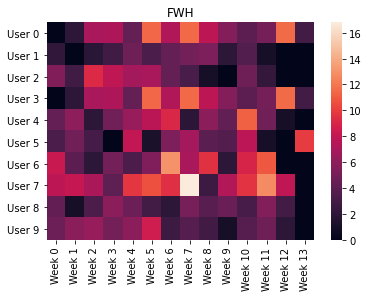

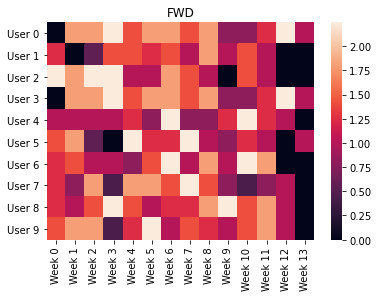

In [151]:
features = [PDH, PWD, FDH, FWH, FWD]
users = get_users(10, 2019)

for i, feature in enumerate(features):
    plot_weekly_feature(video_events, feature, users=users)
    plt.title(feature.__name__)
    plt.show()